In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
import datetime as dat

# Composite models

In [2]:
class spliced_loss_model():
    
    def __init__(self, f1, f2, model_type):
        self.body = f1
        self.tail = f2
        self.model_type = model_type
        if model_type == "disjoint":
            self.d = f1.d + f2.d + 2 
            self.parm_names = np.append(np.append(f1.parm_names, f2.parm_names), 
                                        np.array(['γ','p']))
        elif model_type == "simple" or  model_type == "continuous":
            self.d = f1.d + f2.d + 1
            self.parm_names = np.append(np.append(f1.parm_names, f2.parm_names), 
                                        np.array(['γ']))
        self.body.set_logps(), self.tail.set_logps(), self.body.set_cdf(), self.tail.set_cdf(), self.body.set_pdf(), self.tail.set_pdf(), self.body.set_logds(), self.tail.set_logds(), self.body.set_ppf(), self.tail.set_ppf()

    
    def set_logp(self, X):
        
        body_d, tail_d, logp_body, logp_tail = self.body.d, self.tail.d,\
            self.body.logp_body,self.tail.logp_tail
        
        model_type, cdf1, cdf2, pdf1, pdf2, f2_name = self.model_type, self.body.cdf, self.tail.cdf, self.body.pdf, self.tail.pdf, self.tail.name
        def logp(parms):
            parms_f1, parms_f2, γ = parms[:body_d], \
                parms[body_d: (body_d + tail_d)], \
                    parms[(body_d + tail_d)]
            if "Tail" in f2_name:
                if model_type == "disjoint":
                    p = parms[-1]
                elif model_type == "simple":
                    S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ, γ)
                    s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ, γ)
                    if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                        p =  S1
                    else:
                        p = 0

                elif model_type == "continuous":
                    S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ, γ)
                    s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ, γ)
                    if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                        p =  s2 / (1 - S2) / ( s2 / (1 - S2) + s1 / S1)

                    else:
                        p = 0
            else:
                if model_type == "disjoint":
                    p = parms[-1]
                elif model_type == "simple":
                    S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ)
                    s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ)
                    if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                        p =  S1
                    else:
                        p = 0

                elif model_type == "continuous":
                    S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ)
                    s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ)
                    if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                        p =  s2 / (1 - S2) / ( s2 / (1 - S2) + s1 / S1)

                    else:
                        p = 0
            
            if γ > 0 and p > 0 and p < 1:
                X1 = X[X < γ]
                X2 = X[X >= γ]
                return(len(X1) * np.log(p) + 
                       logp_body(X1, parms_f1, γ) + 
                       len(X2) * np.log(1-p) + logp_tail(X2, parms_f2, γ))
            else:
                return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
        
    def sample(self, parms, n):
        parms_f1, parms_f2, γ = parms[:self.body.d],\
            parms[self.body.d: (self.body.d + self.tail.d)], \
                parms[(self.body.d + self.tail.d)]
        model_type, cdf1, cdf2, pdf1, pdf2, f2_name = self.model_type, self.body.cdf, self.tail.cdf, self.body.pdf, self.tail.pdf, self.tail.name
        if "Tail" in f2_name:
                if model_type == "disjoint":
                    p = parms[-1]
                elif model_type == "simple":
                    S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ, γ)
                    s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ, γ)
                    if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                        p =  S1
                    else:
                        p = 0

                elif model_type == "continuous":
                    S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ, γ)
                    s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ, γ)
                    if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                        p =  s2 / (1 - S2) / ( s2 / (1 - S2) + s1 / S1)

                    else:
                        p = 0
        else:
            if model_type == "disjoint":
                p = parms[-1]
            elif model_type == "simple":
                S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ)
                s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ)
                if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                    p =  S1
                else:
                    p = 0

            elif model_type == "continuous":
                S1, S2 = cdf1(parms_f1, γ), cdf2(parms_f2, γ)
                s1, s2 = pdf1(parms_f1, γ), pdf2(parms_f2, γ)
                if S1 > 0 and S2 < 1 and s1 > 0 and s2 > 0 :
                    p =  s2 / (1 - S2) / ( s2 / (1 - S2) + s1 / S1)

                else:
                    p = 0        
        ber_rvs = np.random.binomial(1, p, size=n)
        unif_rvs = np.random.uniform(size = n)
        if "Tail" in f2_name:
            body_rvs = self.body.ppf(parms_f1, 
                                     self.body.cdf(parms_f1, γ) * unif_rvs )
            tail_rvs = self.tail.ppf(parms_f2, γ,
                                     1 - (1 - self.tail.cdf(parms_f2, γ, γ)) * unif_rvs)
        else:
            body_rvs = self.body.ppf(parms_f1, 
                                     self.body.cdf(parms_f1, γ) * unif_rvs )
            tail_rvs = self.tail.ppf(parms_f2,
                                     1 - (1 - self.tail.cdf(parms_f2, γ)) * unif_rvs)
            
        
        return(ber_rvs * body_rvs + (1 - ber_rvs) * tail_rvs)
    
    def set_logd(self, parms):
        parms_f1, parms_f2, γ = parms[:,:self.body.d],\
            parms[:,self.body.d: (self.body.d + self.tail.d)],\
                parms[:,(self.body.d + self.tail.d)] 
        model_type, cdf1, cdf2, pdf1, pdf2, f2_name = self.model_type, self.body.cdf, self.tail.cdf, self.body.pdf, self.tail.pdf, self.tail.name
        
        if model_type == "disjoint":
            p = parms[:,-1]
        elif model_type == "simple":
            p = np.array([cdf1(parm_f1, γ[j] ) for j, parm_f1 in enumerate(parms_f1)])
        elif model_type == "continuous":
            if "Tail" in f2_name:
                p = np.array([pdf2(parm_f2, gam, gam) / (1 - cdf2(parm_f2, gam, gam)) / ( pdf2(parm_f2, gam, gam) / (1 - cdf2(parm_f2, gam, gam)) + pdf1(parm_f1, gam) / cdf1(parm_f1, gam)) for parm_f1, parm_f2, gam in zip(parms_f1, parms_f2, γ) ])
            else:
                p = np.array([pdf2(parm_f2, gam) / (1 - cdf2(parm_f2, gam)) / ( pdf2(parm_f2, gam) / (1 - cdf2(parm_f2, gam)) + pdf1(parm_f1, gam) / cdf1(parm_f1, gam)) for parm_f1, parm_f2, gam in zip(parms_f1, parms_f2, γ) ])
        def logd(x):
            res = np.zeros(len(γ))
            s = np.logical_and(p > 0, p < 1)
            s1 = np.logical_and(s, x < γ)
            s2 = np.logical_and(s, x >= γ)
            res1 = self.body.logd_body(x, parms_f1[s1], γ[s1]) + np.log(p[s1])    
            res2 = self.tail.logd_tail(x, parms_f2[s2], γ[s2]) + np.log(1 - p[s2])
            res[np.where(s1)] = res1
            res[np.where(s2)] = res2
            res[np.where(np.invert(s))] = - np.inf
            return(res)
        self.logd = logd
    
    def cdf(self, parms, x):
        parms_f1, parms_f2, γ = parms[:self.body.d],\
            parms[self.body.d: (self.body.d + self.tail.d)], \
                parms[(self.body.d + self.tail.d)]
        model_type, cdf1, cdf2, pdf1, pdf2, f2_name = self.model_type, self.body.cdf, self.tail.cdf, self.body.pdf, self.tail.pdf, self.tail.name
        if model_type == "disjoint":
            p = parms[-1]
        elif model_type == "simple":
            p = cdf1(parms_f1, γ)
        elif model_type == "continuous":
            if "Tail" in f2_name:
                p =  pdf2(parms_f2, γ, γ) / (1 - cdf2(parms_f2, γ, γ)) / ( pdf2(parms_f2, γ, γ) / (1 - cdf2(parms_f2, γ, γ)) + pdf1(parms_f1, γ) / cdf1(parms_f1, γ)) 
            else:
                p =  pdf2(parms_f2, γ) / (1 - cdf2(parms_f2, γ)) / ( pdf2(parms_f2, γ) / (1 - cdf2(parms_f2, γ)) + pdf1(parms_f1, γ) / cdf1(parms_f1, γ)) 
        
        
        if x <= γ:
            return(p * cdf1(parms_f1, x) / cdf1(parms_f1, γ))
        else:
            if "Tail" in f2_name:
                return(p + (1-p) * (cdf2(parms_f2, γ,  x)- cdf2(parms_f2, γ,  γ)) / (1 - cdf2(parms_f2, γ, γ)) )
            else:
                return(p + (1-p) * (cdf2(parms_f2, x)- cdf2(parms_f2, γ)) / (1 - cdf2(parms_f2, γ)) )
    
    def ppf(self, parms, y):
        low, up = 0, 1e8
        err = 1e-6
        while up - low > err:
            new = (up + low) / 2
            val = self.cdf(parms, new)
            if val > y:
                up = new
            else: 
                low = new
        return(new)
    

In [3]:
f1, f2 =  bsm.loss_model("Lomax", ["r1", "m1"]), bsm.loss_model("Lomax", ["α2", "σ2"])
f = spliced_loss_model(f1 , f2, "continuous") 
f.set_cdf(), f.set_ppf()
r1_prior, m1_prior = bsm.prior_model('gamma','r1', 1, 1), bsm.prior_model('fixed','m1', 1, 1)
α2_prior, σ2_prior = bsm.prior_model('gamma','α2',1, 1), bsm.prior_model('gamma','σ2',1, 1)
γ_prior, p_prior =  bsm.prior_model('fixed','γ',2, 1), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([r1_prior, m1_prior, α2_prior, σ2_prior, γ_prior])
parms = prior_spliced_model.sample(1).values[0]

AttributeError: 'spliced_loss_model' object has no attribute 'set_cdf'

In [ ]:
parms = np.array([1.2786364 , 1.92896647, 1.39653302, 2.30347771, 3.92126287])
f.cdf(parms, 4)
# ,f.ppf(parms, 0.5)

In [ ]:
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# ausautoBI8999 = pd.read_csv("Data/ausautoBI8999.csv")
# aus = pd.concat([ausautoBI8999[["FinDate", "FinMth" ,"AggClaim"]], 
#                  pd.DataFrame({'year':np.array([dat.datetime.fromisoformat(ausautoBI8999["FinDate"].iloc[k]).year 
#                                                 for k in range(len(ausautoBI8999["FinDate"]))])})
#                 ], axis = 1)
# aus['scaled_aggclaims'] = aus['AggClaim'] / 1e6 
# months = np.unique(aus['FinMth'])
# selec = aus['FinMth'].values == months[0]   
# X = aus['scaled_aggclaims'].iloc[selec].values

In [31]:
f1, f2 =  bsm.loss_model("Exp", ["r1"]), loss_model("Pareto-Tail", ["α2"])
f = spliced_loss_model(f1 , f2, "continuous") 
r1_prior, m1_prior = bsm.prior_model('gamma','r1', 1, 1), bsm.prior_model('fixed','m1', 1, 1)
α2_prior = bsm.prior_model('gamma','α2',1, 1)
γ_prior, p_prior =  bsm.prior_model('gamma','γ',1, 1), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([r1_prior, α2_prior, γ_prior])
f.set_logp(X), f.logp(np.array([1, 2, 1.2, 1.2]))

(None, -6570.229376171235)

In [32]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 5000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.0006723403930664062 ;ESS: 2501 ;steps:4 ;particle moved: 99.68%
Generation: 2 ;temperature: 0.0022501407988784194 ;ESS: 2499 ;steps:3 ;particle moved: 98.76%
Generation: 3 ;temperature: 0.006312985623427515 ;ESS: 2499 ;steps:4 ;particle moved: 99.78%
Generation: 4 ;temperature: 0.014944064535935957 ;ESS: 2499 ;steps:3 ;particle moved: 98.46000000000001%
Generation: 5 ;temperature: 0.03229335073031806 ;ESS: 2499 ;steps:3 ;particle moved: 99.1%
Generation: 6 ;temperature: 0.06751152713352465 ;ESS: 2500 ;steps:3 ;particle moved: 99.08%
Generation: 7 ;temperature: 0.14216725957744064 ;ESS: 2500 ;steps:3 ;particle moved: 99.16%
Generation: 8 ;temperature: 0.30322179927773985 ;ESS: 2500 ;steps:3 ;particle moved: 99.3%
Generation: 9 ;temperature: 0.6436718103568198 ;ESS: 2499 ;steps:3 ;particle moved: 99.24%
Generation: 10 ;temperature: 1.0 ;ESS: 3754 ;steps:3 ;particle moved: 99.22%
Wall time: 26.

[0.00203576 1.39646018 1.83155974] -4651.502313072686 9271.129964625808 9279.526231029826


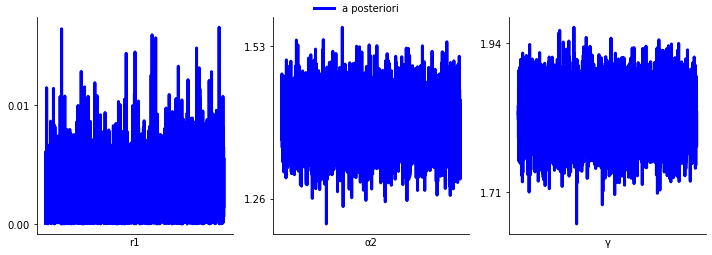

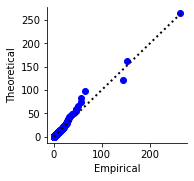

In [33]:
print(trace.mean().values, log_marg, DIC, WAIC)
# bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

In [34]:
X0 = f.sample(trace.mean().values, 10000)

In [35]:
def qq_plot_en(X, X0, color):
    qs = np.arange(0.01,0.99, 0.01)
    
    df_quantile = pd.DataFrame({
        'emp_quant' : pd.Series(X).quantile(qs),
        'lnorm_quant' : pd.Series(X0).quantile(qs)
    })
    df_quantile
    # Quantile-quantile plots
    fig, axs = plt.subplots(1, 1, figsize=(2.5, 2.5))
    
    plt.plot(df_quantile.emp_quant, df_quantile.lnorm_quant, c= color, lw=3)
    
    x = np.linspace(0, max(df_quantile.emp_quant), 100)
    
    plt.plot(x, x, ":k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Empirical")
    plt.ylabel("Theoretical")

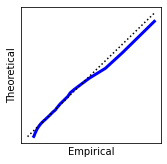

In [36]:
qq_plot_en(X, X0, "blue")